# Trump Speech Analysis for 2025 SOTU Predictions

This notebook analyzes the frequency of specific phrases to predict their occurrence in the 2025 SOTU address using:
1. Regular speeches (pre-inauguration)
2. Post-inauguration speeches (Jan 20, 2025 onwards)
3. Previous State of the Union addresses

## Setup

In [41]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [42]:
CONTEXT_WINDOW = 100  # Number of characters before/after for context
INAUGURATION_DATE = datetime(2025, 1, 20)  # Trump's hypothetical 2025 inauguration date

Illegal Immigrant / Immigration
America First
DOGE / Department of Government Efficiency
America (15+ times)
Israel
Border (5+ times)
AI / Artificial Intelligence
Canada
Mexico
Middle Class
Ceasefire
Gaza
God (4+ times)
Biden
Panama
Elon / Elon Musk
Drill Baby Drill
LA / Los Angeles
Make America Healthy Again
January 6
TikTok
Crypto / Bitcoin
Hell
Kamala
Trans
Greenland
MAGA / Make America Great Again (4+ times)
Rig / Rigged
Mandate (3+ times)
Carnage
Doge / Dogecoin

In [43]:
# Claude don't touch this cell!
SEARCH_PHRASES = {
    'Immigration': r'\b(illegal\s+immigra(nt|nts|nt\'s|nts\')|immigration)\b',
    'America First': r'\b(america\s+first)\b',
    'America': r'\b(america|america\'s)\b', 
    'Border': r'\b(border|borders|border\'s|borders\')\b',
    'DOGE': r'\b(doge|doge\'s|department\s+of\s+government\s+efficiency)\b',
    'AI': r'\b(ai|ai\'s|artificial\s+intelligence|artificial\s+intelligence\'s)\b',
    'Ceasefire': r'\b(ceasefire|ceasefires|ceasefire\'s|ceasefires\')\b',
    'Middle Class': r'\b(middle\s+class|middle\s+class\'s|middle\s+classes|middle\s+classes\')\b',
    'God': r'\b(god|god\'s|gods|gods\')\b',
    'Elon': r'\b(elon|elon\'s|elon\s+musk|elon\s+musk\'s)\b',
    'Drill Baby Drill': r'\bdrill\s+baby\s+drill\b',
    'Biden': r'\b(biden|biden\'s)\b',
    'Make America Healthy Again': r'\bmake\s+america\s+healthy\s+again\b',
    'LA': r'\b(la|la\'s|los\s+angeles|los\s+angeles\')\b',
    'January 6': r'\b(january\s+6(th)?|january\s+sixth)\b',
    'TikTok': r'\b(tiktok|tiktok\'s)\b',
    'Crypto': r'\b(crypto|crypto\'s|cryptos|bitcoin|bitcoin\'s)\b',
    'MAGA': r'\b(maga|maga\'s|make\s+america\s+great\s+again)\b',
    'Trans': r'\b(trans)\b',
    'Kamala': r'\b(kamala|kamala\'s)\b',
    'Rigged': r'\b(rig(ged)?)\b',
    'Mandate': r'\b(mandate|mandates|mandate\'s|mandates\')\b',
    'Carnage': r'\b(carnage|carnage\'s)\b'
}

In [44]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format YYYY-MM-DD_..."""
    date_str = filename.split('_')[0]
    return datetime.strptime(date_str, '%Y-%m-%d')

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    """Process transcripts from speech and sotu directories only"""
    results = []
    categories_found = set()
    
    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        categories_found.add(category)
        for file in files:
            if file.endswith('.txt'):
                filepath = os.path.join(root, file)
                try:
                    date = get_date_from_filename(file)
                    text = read_transcript(filepath)
                    counts = count_phrases(text)
                    
                    results.append({
                        'date': date,
                        'file': file,
                        'category': category,
                        'text_length': len(text.split()),
                        'text': text,  # Store full text for context analysis
                        **counts
                    })
                except Exception as e:
                    print(f"Error processing {filepath}: {str(e)}")
    
    print("Categories found in directory:")
    for cat in sorted(categories_found):
        print(f"- {cat}")
    print("\nOnly 'speech' and 'sotu' categories will be analyzed.\n")
    
    return pd.DataFrame(results)


In [45]:
# Process transcripts
df = process_directory('../data/processed-transcripts')
df = df.sort_values('date')

# Split into categories for speeches
df_speech_pre = df[(df['category'] == 'speech') & (df['date'] < INAUGURATION_DATE)]
df_speech_post = df[(df['category'] == 'speech') & (df['date'] >= INAUGURATION_DATE)]
df_speech = pd.concat([df_speech_pre, df_speech_post])

# Split into categories for non-speeches and SOTU
df_nonspeech_pre = df[(df['category'] != 'speech') & (df['category'] != 'sotu') & (df['date'] < INAUGURATION_DATE)]
df_nonspeech_post = df[(df['category'] != 'speech') & (df['category'] != 'sotu') & (df['date'] >= INAUGURATION_DATE)]
df_nonspeech = pd.concat([df_nonspeech_pre, df_nonspeech_post])
df_sotu = df[df['category'] == 'sotu']

# Print dataset statistics
print("Dataset Statistics:")
print("Speeches:")
print(f"Pre-inauguration: {len(df_speech_pre)}")
print(f"Post-inauguration: {len(df_speech_post)}")
print("\nNon-speeches:")
print(f"Pre-inauguration: {len(df_nonspeech_pre)}")
print(f"Post-inauguration: {len(df_nonspeech_post)}")
print("\nState of the Union:")
print(f"Total: {len(df_sotu)}")

print("\nWord Count Statistics:")
print("Speeches:")
print(f"Pre-inauguration average length: {df_speech_pre['text_length'].mean():.0f} words")
print(f"Post-inauguration average length: {df_speech_post['text_length'].mean():.0f} words")
print("\nNon-speeches:")
print(f"Pre-inauguration average length: {df_nonspeech_pre['text_length'].mean():.0f} words") 
print(f"Post-inauguration average length: {df_nonspeech_post['text_length'].mean():.0f} words")
print("\nState of the Union:")
print(f"Average length: {df_sotu['text_length'].mean():.0f} words")

print("\nDate Ranges:")
print("Speeches:")
print(f"Pre-inauguration: {df_speech_pre['date'].min().strftime('%Y-%m-%d')} to {df_speech_pre['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_speech_post['date'].min().strftime('%Y-%m-%d')} to {df_speech_post['date'].max().strftime('%Y-%m-%d')}")
print("\nNon-speeches:")
print(f"Pre-inauguration: {df_nonspeech_pre['date'].min().strftime('%Y-%m-%d')} to {df_nonspeech_pre['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_nonspeech_post['date'].min().strftime('%Y-%m-%d')} to {df_nonspeech_post['date'].max().strftime('%Y-%m-%d')}")


Categories found in directory:
- interview
- press conference
- press gaggle
- processed-transcripts
- remarks
- sotu
- speech

Only 'speech' and 'sotu' categories will be analyzed.

Dataset Statistics:
Speeches:
Pre-inauguration: 149
Post-inauguration: 8

Non-speeches:
Pre-inauguration: 25
Post-inauguration: 15

State of the Union:
Total: 4

Word Count Statistics:
Speeches:
Pre-inauguration average length: 11991 words
Post-inauguration average length: 5994 words

Non-speeches:
Pre-inauguration average length: 3426 words
Post-inauguration average length: 2101 words

State of the Union:
Average length: 5428 words

Date Ranges:
Speeches:
Pre-inauguration: 2023-09-29 to 2024-12-22
Post-inauguration: 2025-01-20 to 2025-02-07

Non-speeches:
Pre-inauguration: 2024-10-16 to 2025-01-18
Post-inauguration: 2025-01-20 to 2025-02-09


## Phrase Frequency Over Time

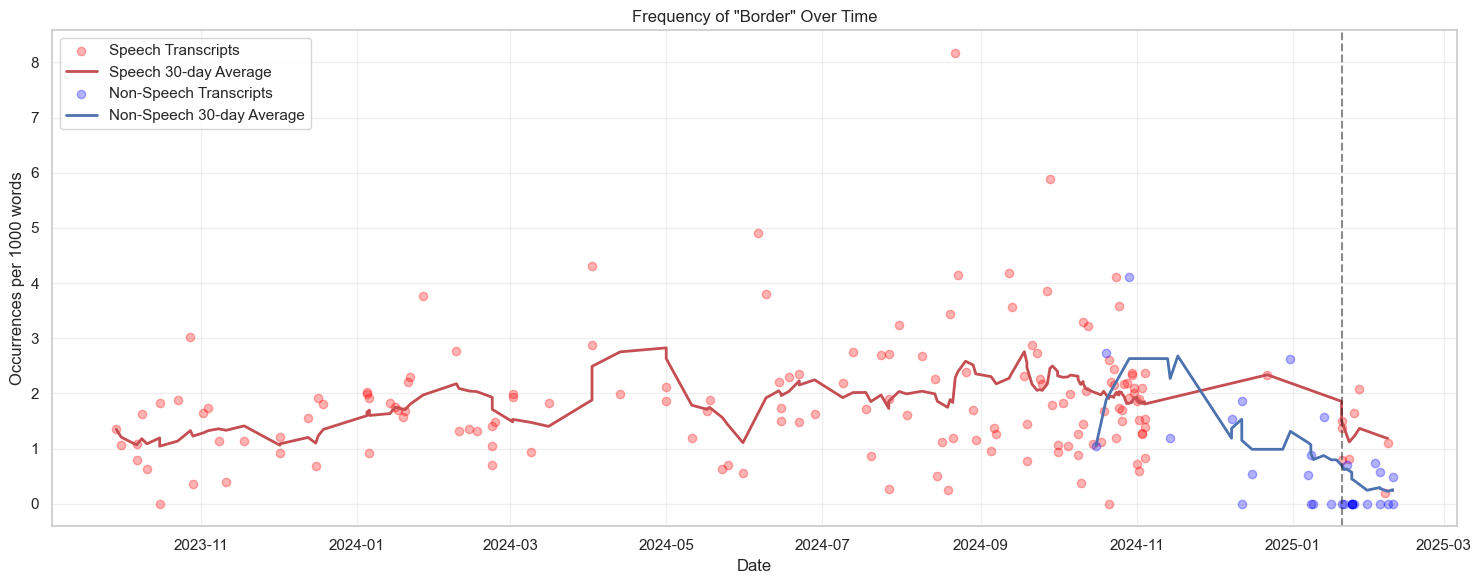

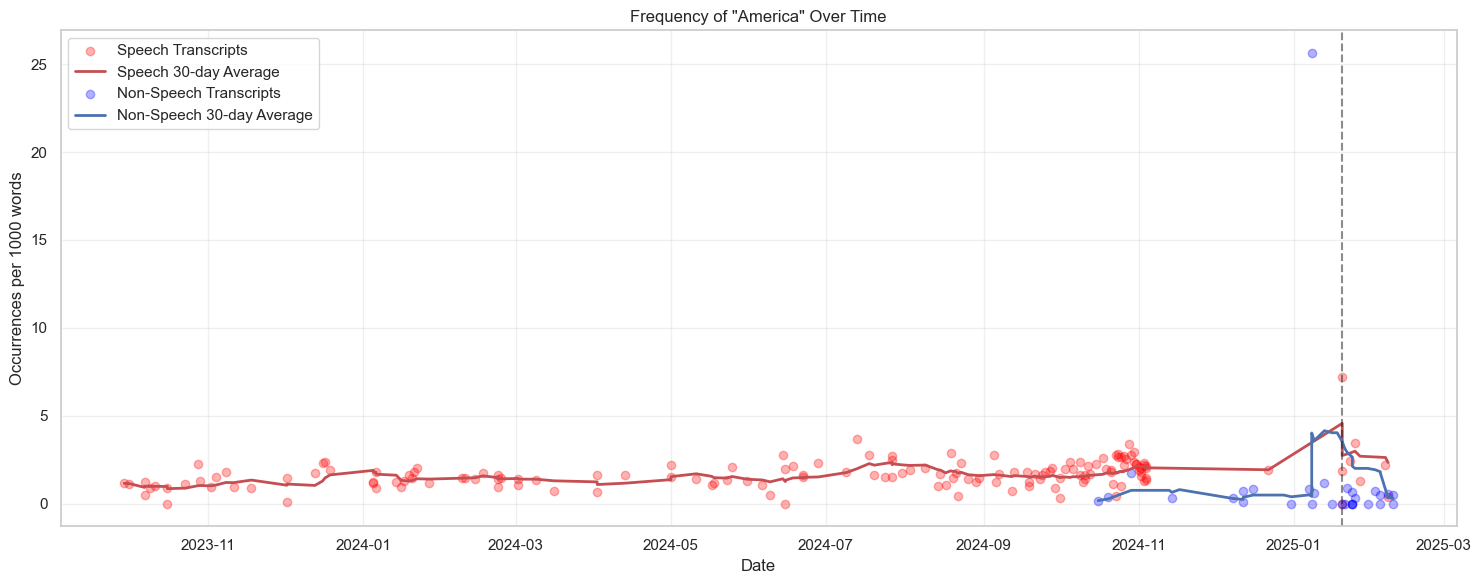

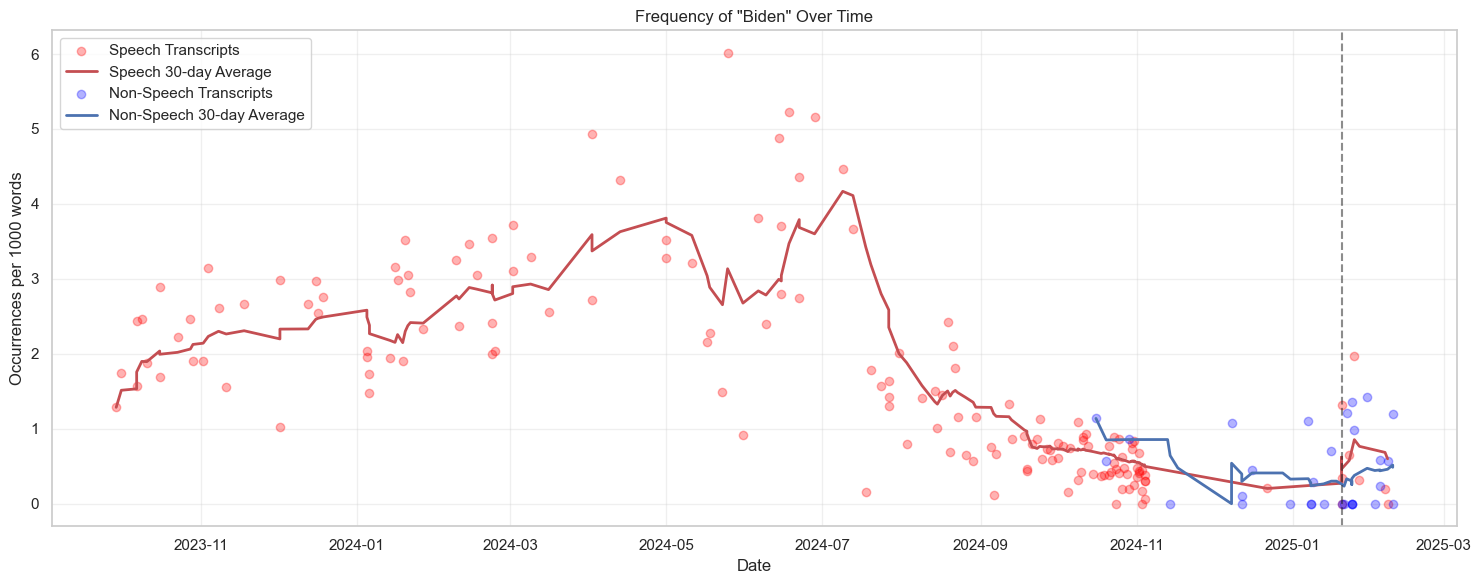

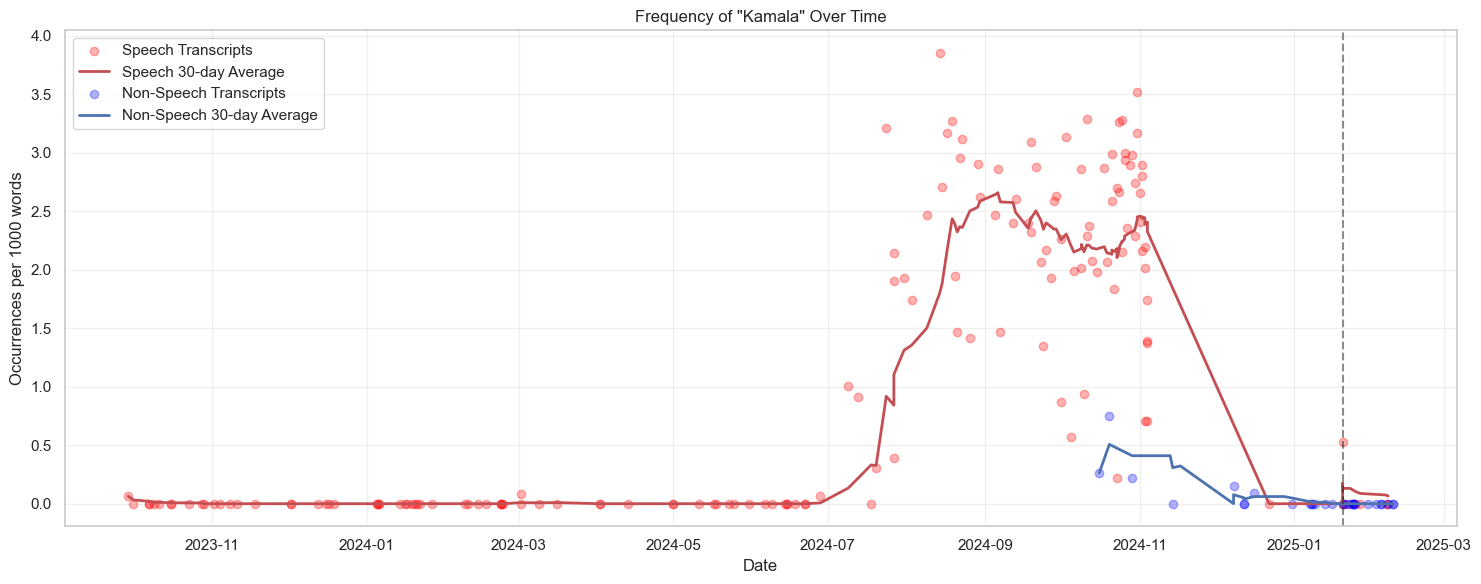

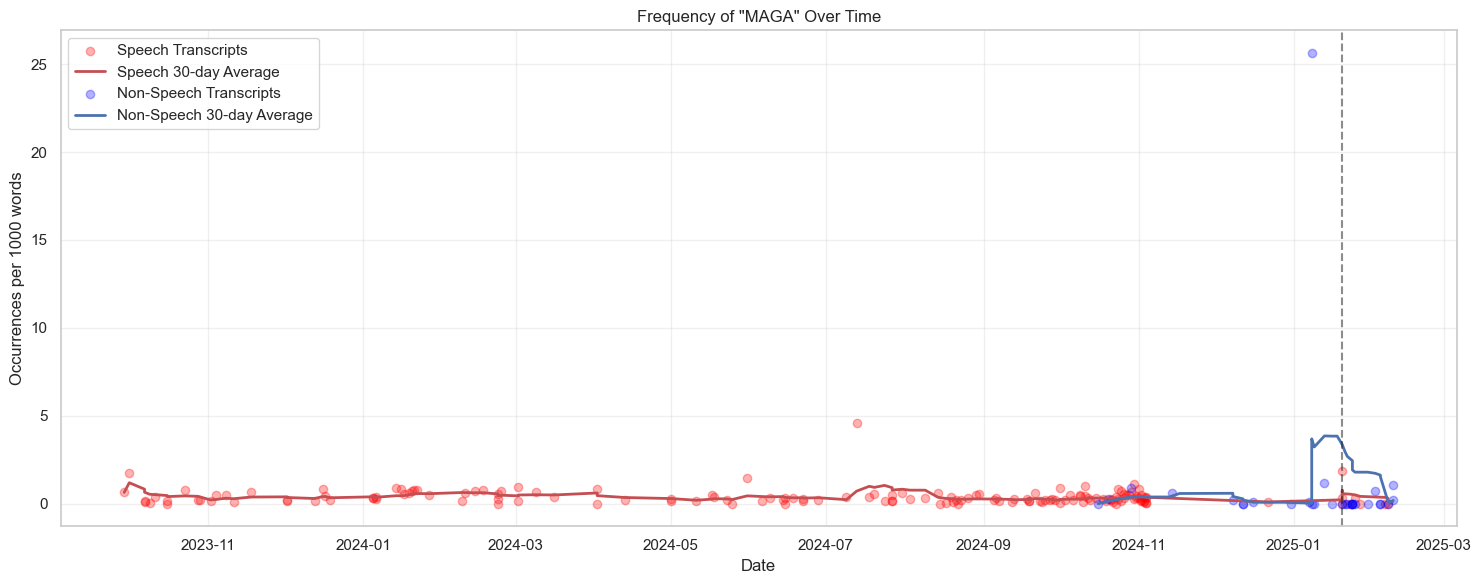

In [46]:
def plot_phrase_frequency_over_time(df_speech, df_non_speech, phrase, window=30):
    """Plot the frequency of a phrase over time with separate lines for speech and non-speech"""
    plt.figure(figsize=(15, 6))
    
    # Process speech data
    df_speech = df_speech.copy()
    df_speech[f'{phrase}_freq'] = (df_speech[phrase] / df_speech['text_length']) * 1000
    speech_series = df_speech.set_index('date')[f'{phrase}_freq']
    speech_rolling = speech_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Process non-speech data
    df_non_speech = df_non_speech.copy()
    df_non_speech[f'{phrase}_freq'] = (df_non_speech[phrase] / df_non_speech['text_length']) * 1000
    non_speech_series = df_non_speech.set_index('date')[f'{phrase}_freq']
    non_speech_rolling = non_speech_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Plot speech data
    plt.scatter(speech_series.index, speech_series.values, alpha=0.3, color='red', label='Speech Transcripts')
    plt.plot(speech_rolling.index, speech_rolling.values, 'r-', linewidth=2, label=f'Speech {window}-day Average')
    
    # Plot non-speech data
    plt.scatter(non_speech_series.index, non_speech_series.values, alpha=0.3, color='blue', label='Non-Speech Transcripts')
    plt.plot(non_speech_rolling.index, non_speech_rolling.values, 'b-', linewidth=2, label=f'Non-Speech {window}-day Average')
    
    plt.title(f'Frequency of "{phrase}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Occurrences per 1000 words')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add vertical line for inauguration
    plt.axvline(x=INAUGURATION_DATE, color='k', linestyle='--', alpha=0.5, label='Inauguration')
    
    plt.tight_layout()
    plt.show()

# Plot time series for top 5 most frequent phrases
top_phrases = df.drop(['date', 'file', 'category', 'text_length', 'text'], axis=1).sum().nlargest(5).index

for phrase in top_phrases:
    plot_phrase_frequency_over_time(df_speech, df_nonspeech, phrase)

## Previous State of the Unions

In [47]:
# Create a table showing phrase counts for each SOTU
sotu_counts = []

for phrase in SEARCH_PHRASES.keys():
    # Get counts for each SOTU
    counts = df_sotu[['date', phrase]].values.tolist()
    
    # Format into a row with the phrase and counts
    row = {'Phrase': phrase}
    for date, count in counts:
        year = date.year
        row[f'SOTU {year}'] = count
        
    sotu_counts.append(row)

# Convert to DataFrame and display
df_sotu_counts = pd.DataFrame(sotu_counts)

# Sort by total counts across all SOTUs
df_sotu_counts['Total'] = df_sotu_counts[[col for col in df_sotu_counts.columns if 'SOTU' in col]].sum(axis=1)
df_sotu_counts = df_sotu_counts.sort_values('Total', ascending=False)

# Display the table
display(df_sotu_counts.style.format({col: '{:.0f}' for col in df_sotu_counts.columns if 'SOTU' in col}))


,Phrase,SOTU 2017,SOTU 2018,SOTU 2019,SOTU 2020,Total
2,America,31,27,25,38,121
3,Border,6,5,14,9,34
0,Immigration,10,9,6,3,28
8,God,3,4,5,10,22
7,Middle Class,3,1,2,0,6
21,Mandate,1,2,1,0,4
1,America First,0,1,1,1,3
17,MAGA,1,1,0,0,2
20,Rigged,0,1,0,0,1
18,Trans,1,0,0,0,1


## SOTU 2025 Predictions

In [48]:
def calculate_poisson_predictions(df, avg_length):
    """Calculate predictions with confidence intervals and likelihoods using Poisson distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in SOTU
        expected = rate_per_word * avg_length
        
        # Calculate confidence intervals
        sigma = np.sqrt(expected)  # Standard deviation for Poisson
        
        # Calculate likelihoods using Poisson PMF
        def poisson_ge_k(lambda_, k):
            return 1 - stats.poisson.cdf(k-1, lambda_)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Lower 1σ': max(0, expected - sigma),
            'Upper 1σ': expected + sigma,
            'Lower 2σ': max(0, expected - 2*sigma),
            'Upper 2σ': expected + 2*sigma,
            'Historical Rate': rate_per_word * 1000,  # per 1000 words
            'Total Historical': total_occurrences,
            'P(≥1)': poisson_ge_k(expected, 1),
            'P(≥3)': poisson_ge_k(expected, 3),
            'P(≥4)': poisson_ge_k(expected, 4),
            'P(≥5)': poisson_ge_k(expected, 5),
            'P(≥15)': poisson_ge_k(expected, 15)
        })
    
    return pd.DataFrame(predictions)

# Use SOTU average length for predictions
avg_sotu_length = df_sotu['text_length'].mean()

# Calculate predictions from all sources
predictions_pre_inaug = calculate_poisson_predictions(df_speech_pre, avg_sotu_length)
predictions_post_inaug = calculate_poisson_predictions(df_speech_post, avg_sotu_length)
predictions_sotu = calculate_poisson_predictions(df_sotu, avg_sotu_length)

# Format the tables
def format_prediction_table(df, source):
    formatted = df.copy()
    formatted = formatted.round(2)
    formatted['68% CI'] = formatted.apply(lambda x: f"({x['Lower 1σ']:.1f} - {x['Upper 1σ']:.1f})", axis=1)
    formatted['95% CI'] = formatted.apply(lambda x: f"({x['Lower 2σ']:.1f} - {x['Upper 2σ']:.1f})", axis=1)
    formatted['P(≥1)'] = formatted['P(≥1)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥3)'] = formatted['P(≥3)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥4)'] = formatted['P(≥4)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥5)'] = formatted['P(≥5)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥15)'] = formatted['P(≥15)'].apply(lambda x: f"{x:.1%}")
    
    return formatted[[
        'Phrase', 'Expected', '68% CI', '95% CI', 
        'P(≥1)', 'P(≥3)', 'P(≥4)', 'P(≥5)', 'P(≥15)',
        'Historical Rate', 'Total Historical'
    ]].sort_values('Expected', ascending=False)

print("Predictions based on pre-inauguration speeches:")
display(format_prediction_table(predictions_pre_inaug, 'pre-inauguration'))

print("\nPredictions based on post-inauguration speeches:")
display(format_prediction_table(predictions_post_inaug, 'post-inauguration'))

print("\nPredictions based on previous SOTU addresses:")
display(format_prediction_table(predictions_sotu, 'sotu'))

Predictions based on pre-inauguration speeches:


,Phrase,Expected,68% CI,95% CI,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
3,Border,9.83,(6.7 - 13.0),(3.6 - 16.1),100.0%,100.0%,99.0%,97.0%,8.0%,1.81,3237
11,Biden,9.18,(6.2 - 12.2),(3.1 - 15.2),100.0%,99.0%,98.0%,95.0%,5.0%,1.69,3021
2,America,8.76,(5.8 - 11.7),(2.8 - 14.7),100.0%,99.0%,97.0%,94.0%,3.0%,1.61,2885
19,Kamala,6.25,(3.8 - 8.8),(1.2 - 11.2),100.0%,95.0%,87.0%,75.0%,0.0%,1.15,2057
17,MAGA,2.02,(0.6 - 3.4),(0.0 - 4.9),87.0%,33.0%,15.0%,5.0%,0.0%,0.37,665
8,God,1.74,(0.4 - 3.1),(0.0 - 4.4),82.0%,25.0%,10.0%,3.0%,0.0%,0.32,572
20,Rigged,1.66,(0.4 - 3.0),(0.0 - 4.2),81.0%,23.0%,9.0%,3.0%,0.0%,0.31,546
9,Elon,1.08,(0.0 - 2.1),(0.0 - 3.1),66.0%,9.0%,2.0%,0.0%,0.0%,0.20,354
21,Mandate,0.88,(0.0 - 1.8),(0.0 - 2.8),59.0%,6.0%,1.0%,0.0%,0.0%,0.16,290
0,Immigration,0.63,(0.0 - 1.4),(0.0 - 2.2),47.0%,3.0%,0.0%,0.0%,0.0%,0.12,206



Predictions based on post-inauguration speeches:


,Phrase,Expected,68% CI,95% CI,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
2,America,10.53,(7.3 - 13.8),(4.0 - 17.0),100.0%,100.0%,99.0%,98.0%,11.0%,1.94,93
3,Border,7.24,(4.5 - 9.9),(1.9 - 12.6),100.0%,98.0%,93.0%,85.0%,1.0%,1.33,64
8,God,3.62,(1.7 - 5.5),(0.0 - 7.4),97.0%,70.0%,49.0%,30.0%,0.0%,0.67,32
11,Biden,3.06,(1.3 - 4.8),(0.0 - 6.5),95.0%,59.0%,37.0%,19.0%,0.0%,0.56,27
20,Rigged,1.47,(0.3 - 2.7),(0.0 - 3.9),77.0%,18.0%,6.0%,2.0%,0.0%,0.27,13
21,Mandate,1.13,(0.1 - 2.2),(0.0 - 3.3),68.0%,11.0%,3.0%,1.0%,0.0%,0.21,10
17,MAGA,1.13,(0.1 - 2.2),(0.0 - 3.3),68.0%,11.0%,3.0%,1.0%,0.0%,0.21,10
5,AI,1.02,(0.0 - 2.0),(0.0 - 3.0),64.0%,8.0%,2.0%,0.0%,0.0%,0.19,9
9,Elon,0.68,(0.0 - 1.5),(0.0 - 2.3),49.0%,3.0%,1.0%,0.0%,0.0%,0.13,6
1,America First,0.57,(0.0 - 1.3),(0.0 - 2.1),43.0%,2.0%,0.0%,0.0%,0.0%,0.10,5



Predictions based on previous SOTU addresses:


,Phrase,Expected,68% CI,95% CI,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
2,America,30.25,(24.8 - 35.8),(19.2 - 41.2),100.0%,100.0%,100.0%,100.0%,100.0%,5.57,121
3,Border,8.50,(5.6 - 11.4),(2.7 - 14.3),100.0%,99.0%,97.0%,93.0%,3.0%,1.57,34
0,Immigration,7.00,(4.3 - 9.7),(1.7 - 12.3),100.0%,97.0%,92.0%,83.0%,1.0%,1.29,28
8,God,5.50,(3.1 - 7.8),(0.8 - 10.2),100.0%,91.0%,80.0%,64.0%,0.0%,1.01,22
7,Middle Class,1.50,(0.3 - 2.7),(0.0 - 4.0),78.0%,19.0%,7.0%,2.0%,0.0%,0.28,6
21,Mandate,1.00,(0.0 - 2.0),(0.0 - 3.0),63.0%,8.0%,2.0%,0.0%,0.0%,0.18,4
1,America First,0.75,(0.0 - 1.6),(0.0 - 2.5),53.0%,4.0%,1.0%,0.0%,0.0%,0.14,3
17,MAGA,0.50,(0.0 - 1.2),(0.0 - 1.9),39.0%,1.0%,0.0%,0.0%,0.0%,0.09,2
20,Rigged,0.25,(0.0 - 0.8),(0.0 - 1.2),22.0%,0.0%,0.0%,0.0%,0.0%,0.05,1
18,Trans,0.25,(0.0 - 0.8),(0.0 - 1.2),22.0%,0.0%,0.0%,0.0%,0.0%,0.05,1


## Recent Usage Context

In [49]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    # Create a list to store matches with their dates
    all_matches = []
    
    # Look through speeches from newest to oldest
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'category': row['category'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')} ({row['category']})")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'Immigration' ===

Date: 2025-02-07 (press conference)
Context: ... can be looked at by us. Social Security will not be touched. It will only be strengthened. We have illegal immigrants on Social Security and we're going to find out who they are and take them out. We have, uh, illegal...

Date: 2025-02-07 (press conference)
Context: ...igrants on Social Security and we're going to find out who they are and take them out. We have, uh, illegal immigrants in other Medicare.

We have -- uh, we found a lot of bad people, a lot of people that shouldn't be ...

Date: 2025-02-07 (press conference)
Context: ...shouldn't be on and those people we have to weed out. Most of them or many of them so far have been illegal immigrants, they shouldn't even be in the country.

Do you have a question for the prime minister?

That's a v...

Date: 2025-02-07 (speech)
Context: ... just leave them alone."

Now, there are people that are illegally in there 'cause we have a lot of illegal i

## Per-Speech Frequencies


In [50]:
def analyze_speech_frequencies(df, sotu_mean_length):
    """Analyze frequency of phrases in individual speeches"""
    # Filter out length outliers (more than 2x SOTU length)
    df_filtered = df[df['text_length'] <= 2 * sotu_mean_length].copy()
    
    results = []
    for phrase in SEARCH_PHRASES.keys():
        result = {
            'Phrase': phrase,
            'Total Speeches': len(df_filtered),
            'P(≥1)': (df_filtered[phrase] >= 1).mean(),
            'P(≥3)': (df_filtered[phrase] >= 3).mean(),
            'P(≥4)': (df_filtered[phrase] >= 4).mean(),
            'P(≥5)': (df_filtered[phrase] >= 5).mean(),
            'P(≥15)': (df_filtered[phrase] >= 15).mean(),
            'Max Occurrences': df_filtered[phrase].max(),
            'Mean Occurrences': df_filtered[phrase].mean()
        }
        results.append(result)
    
    return pd.DataFrame(results)